# Base VGG training and testing

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Constants (parameters) initialization

In [ ]:
device_id = 0
num_workers = 4

batch_size = 4
default_learning_rate = 0.005

## CIFAR-10 data load and preproc

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display
import pickle
from scipy.stats import t
import math

In [ ]:
%ls

sample_data/


In [ ]:
# add our package dir to path 
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Make sure you are using the right device.

In [ ]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
Tesla T4


In [ ]:
class PartialDataset(Dataset):
    def __init__(self, dataset, n_items=10):
        self.dataset = dataset
        self.n_items = n_items
        
    def __getitem__(self):
        return self.dataset.__getitem__()
    
    def __len__(self):
        return min(self.n_items, len(self.dataset))

In [ ]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_transform = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize
    ])
val_transform = transforms.Compose(
    [transforms.ToTensor(),
    normalize
    ])

dataset_train = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_val = datasets.CIFAR10(root='../data/', train=False, download=True, transform=val_transform)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)


n_items = 10
dataset_train_part = PartialDataset(dataset_train, n_items)
train_loader_part = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


Make sure that dataloader works as expected by observing one sample from it.

tensor([[[-0.0510, -0.0118,  0.0353,  ...,  0.0039, -0.0039,  0.0118],
         [-0.0588, -0.0196,  0.0275,  ..., -0.0196, -0.0196, -0.0039],
         [-0.0667, -0.0275,  0.0196,  ..., -0.0353, -0.0353, -0.0196],
         ...,
         [-0.1529, -0.1059, -0.0667,  ..., -0.1843, -0.2000, -0.2314],
         [-0.1529, -0.1294, -0.0824,  ..., -0.2000, -0.1843, -0.2471],
         [-0.1529, -0.1451, -0.0745,  ..., -0.2000, -0.2078, -0.2549]],

        [[ 0.1765,  0.1922,  0.2078,  ...,  0.1843,  0.2000,  0.2157],
         [ 0.1686,  0.1843,  0.2000,  ...,  0.1686,  0.1843,  0.2000],
         [ 0.1608,  0.1765,  0.1922,  ...,  0.1529,  0.1686,  0.1843],
         ...,
         [ 0.0039,  0.0275,  0.0431,  ..., -0.0431, -0.0510, -0.0588],
         [-0.0039, -0.0039,  0.0275,  ..., -0.0510, -0.0353, -0.0667],
         [ 0.0118,  0.0039,  0.0275,  ..., -0.0588, -0.0588, -0.0824]],

        [[ 0.2392,  0.2706,  0.2941,  ...,  0.2784,  0.3020,  0.3176],
         [ 0.2314,  0.2549,  0.2863,  ...,  0

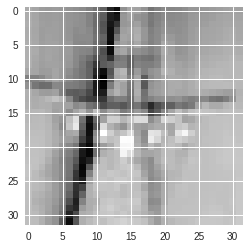

In [ ]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/DeepLearningSeminar

## Models implementation

In [ ]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()
        
    return parameters_n

In [ ]:
class VGG_A_BN(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num = train_num


          

    def forward(self, x):
      x = self.stage1(x)
      x = self.stage2(x)
      x = self.stage3(x)
      x = self.stage4(x)
      x = self.stage5(x)
      x = self.stage6(x.view(-1, 512*1*1))

      return x


In [ ]:
class VGG_A_Group(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.GroupNorm(16,64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.GroupNorm(16,128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(16,256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(16,256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(16,512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(16,512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(16,512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(16,512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num = train_num



    def forward(self, x):
      x = self.stage1(x)
      x = self.stage2(x)
      x = self.stage3(x)
      x = self.stage4(x)
      x = self.stage5(x)
      x = self.stage6(x.view(-1, 512*1*1))

      return x


In [ ]:
class VGG_A_Instance(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num = train_num



    def forward(self, x):
      x = self.stage1(x)
      x = self.stage2(x)
      x = self.stage3(x)
      x = self.stage4(x)
      x = self.stage5(x)
      x = self.stage6(x.view(-1, 512*1*1))

      return x

In [ ]:
class VGG_A_Layer(nn.Module):
    def __init__(self, inp_ch=3, num_classes=10, train_num=0):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.LayerNorm([64, 32, 32]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LayerNorm([128, 16, 16]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.LayerNorm([256, 8, 8]),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.LayerNorm([256, 8, 8]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, 4, 4]),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, 4, 4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, 2, 2]),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.LayerNorm([512, 2, 2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.stage6 = nn.Sequential(
            nn.Linear(512*1*1, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
        self.epoch = 0
        self.write = True
        self.train_num = train_num




    def forward(self, x):
      x = self.stage1(x)
      x = self.stage2(x)
      x = self.stage3(x)
      x = self.stage4(x)
      x = self.stage5(x)
      x = self.stage6(x.view(-1, 512*1*1))
      return x

## Final preparations for training

In [ ]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---Size
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [ ]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()
        grad = []
        learning_curve[epoch] = 0
        for data in train_loader:

            
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)

            learning_curve[epoch] += loss.item()
            loss.backward()
            grad.append(model.stage6[4].weight.grad.clone())
            optimizer.step()
        grads.append(grad)
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    return val_accuracy_curve, train_accuracy_curve

## Training

In [ ]:
def train_vgg_a(epo,lr, seed_val, norm_type):
  set_random_seeds(seed_value=seed_val, device=device)
  if norm_type == "layer":
    model = VGG_A_Layer()
  elif norm_type == "bn":
    model = VGG_A_BN()
  elif norm_type == "group":
    model = VGG_A_Group()
  else:
    model = VGG_A_Instance()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  criterion = nn.CrossEntropyLoss()


  return train(model, 
        optimizer, 
        criterion, 
        train_loader,
        val_loader,
        epochs_n=epo)


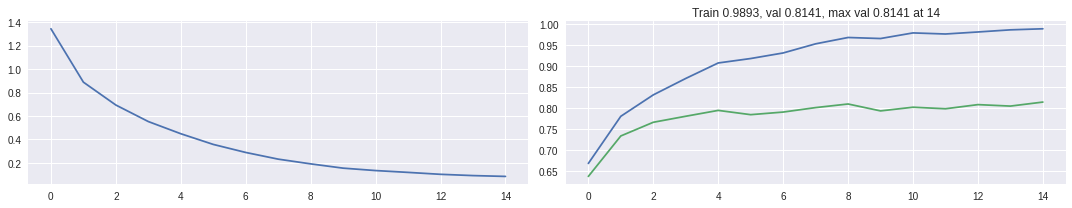

100%|██████████| 15/15 [53:44<00:00, 214.95s/epoch]


In [ ]:
save = True
trains_num = 6
epo = 15
lr = 0.00005


seed_val = 2000
for i in range( 5):

  val_acc, train_acc = train_vgg_a(epo,lr, seed_val + i, norm_type="group")

  pickle.dump(train_acc, open("train_acc_Group" + str(i) + ".p", "wb"))
  pickle.dump(val_acc, open("val_acc_Group" + str(i) + ".p", "wb"))


  val_acc,train_acc = train_vgg_a(epo,lr, seed_val + i, norm_type="instance")
  pickle.dump(train_acc, open("train_acc_Instance" + str(i) + ".p", "wb"))
  pickle.dump(val_acc, open("val_acc_Instance" + str(i) + ".p", "wb"))


  val_acc, train_acc = train_vgg_a(epo,lr, seed_val + i, norm_type="layer")
  
  pickle.dump(train_acc, open("train_acc_Layer" + str(i) + ".p", "wb"))
  pickle.dump(val_acc, open("val_acc_Layer" + str(i) + ".p", "wb"))


  val_acc, train_acc = train_vgg_a(epo,lr, seed_val + i, norm_type="bn")
  pickle.dump(train_acc, open("train_acc_BN" + str(i) + ".p", "wb"))
  pickle.dump(val_acc, open("val_acc_BN" + str(i) + ".p", "wb"))

##Visualizing

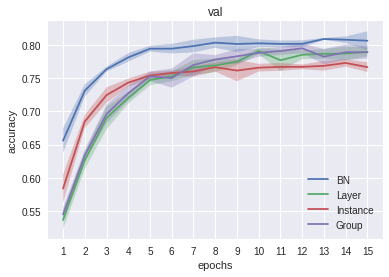

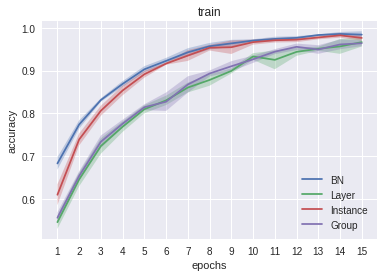

In [ ]:
names = ["BN", "Layer", "Instance", "Group"]
inds = [0, 1, 3, 4, 5]
ppf = t(df=4).ppf(0.975)
import pickle
for metric in ["val", "train"]:
  fig, ax = plt.subplots()
  for name in names:
    res = np.zeros(5*15).reshape((5,15))
    for i, ind in enumerate(inds):
      res[i] = np.array(pickle.load( open("{}_acc_{}{}.p".format(metric,name,ind), "rb" )))
    mean = np.mean(res, axis=0)
    conf = ppf * np.std(res, axis=0) / np.sqrt(5)
    ax.plot(np.arange(1,16), mean, label=name)
    ax.fill_between(np.arange(1,16), mean - conf, mean + conf,alpha=0.3)
  ax.legend()
  ax.set_xticks(np.arange(1,16))
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.title(metric)
  plt.show()